In [1]:
import warnings 
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, BatchNormalization, Masking, Bidirectional, GRU, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Flatten
from tensorflow.keras.optimizers import Adam, AdamW
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import backend as K
import tensorflow as tf
from sklearn.metrics import classification_report
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import Sequence

import random
import matplotlib.pyplot as plt
import seaborn as sns
import re
import json
from tqdm import tqdm

2024-04-26 21:04:46.980066: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-26 21:04:46.980168: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-26 21:04:47.125584: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


#### Check if GPU is available or not

In [2]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
        print(f"Using GPU: {gpus[0].name}")
    except RuntimeError as e:
        print(e)
else:
    print("GPU is not available, using CPU instead.")

Using GPU: /physical_device:GPU:0


#### Loading a file with preprocessed purchase sequences of users with at least 3 purchased products

In [3]:
with open('/kaggle/input/users-sequences/users_sequences.json', 'r') as file:
    users_sequences = json.load(file)

print('Number of users/sequences in total:', len(users_sequences))

Number of users/sequences in total: 601263


In [4]:
parameters = {}
parameters['number_of_users_in_total'] = len(users_sequences)
parameters['number_of_sequences_in_total'] = len(users_sequences)

#### Filtering sequences in which at least min_num_of_products_in_sequence of products were purchased, i.e. users who purchased at least min_num_of_products_in_sequence of products

In [5]:
min_num_of_products_in_sequence = 5
filtered_users_sequences = {}

for key, value in users_sequences.items():
    if len(value) >= min_num_of_products_in_sequence:
        filtered_users_sequences[key] = value

print('Number of users/sequences after filtering:', len(filtered_users_sequences))

Number of users/sequences after filtering: 252156


In [6]:
parameters['number_of_sequences_after_filtering'] = len(filtered_users_sequences)
parameters['number_of_users_after_filtering'] = len(filtered_users_sequences)

#### Creating sequences of length sequence_length and splitting the sequences into train, validation and test datasets, so that the last sequence is selected into the test dataset, the penultimate sequence is selected into the validation dataset and all previous ones are selected into the train dataset. Padding with a value of 0 is applied to keep the sequence length equal to sequence_length

In [7]:
sequence_length = 25

def generate_and_split_sequences(data):
    train_sequences = []
    validation_sequences = []
    test_sequences = []
    train_targets = []
    validation_targets = []
    test_targets = []
    train_user_ids = []
    validation_user_ids = []
    test_user_ids = []

    for user_id, products in data.items():
        n = len(products)
        if n < 2:
            continue

        sequences = []
        for i in range(1, n):
            current_seq = products[:i]
            if len(current_seq) < sequence_length:
                padded_seq = [0] * (sequence_length - len(current_seq)) + current_seq
                sequences.append(padded_seq)
            else:
                sequences.append(current_seq[-sequence_length:])

        targets = products[1:]

        if len(sequences) >= 2:
            train_sequences.extend(sequences[:-2])
            train_targets.extend(targets[:-2])
            train_user_ids.extend([user_id] * (len(sequences) - 2))

            validation_sequences.append(sequences[-2])
            validation_targets.append(targets[-2])
            validation_user_ids.append(user_id)

            test_sequences.append(sequences[-1])
            test_targets.append(targets[-1])
            test_user_ids.append(user_id)
        elif len(sequences) == 1:
            test_sequences.append(sequences[0])
            test_targets.append(targets[0])
            test_user_ids.append(user_id)

    return {
        'train': (train_sequences, train_targets, train_user_ids),
        'validation': (validation_sequences, validation_targets, validation_user_ids),
        'test': (test_sequences, test_targets, test_user_ids)
    }

datasets = generate_and_split_sequences(filtered_users_sequences)

In [8]:
parameters['sequence_length'] = sequence_length

#### Assigning obtained datasets to a clearer form

In [9]:
X_train = datasets['train'][0]
y_train = datasets['train'][1]

X_val = datasets['validation'][0]
y_val = datasets['validation'][1]

X_test = datasets['test'][0]
y_test = datasets['test'][1]

print("An example of what sequences and targets look like:\n\nSequences:\n", X_train[-10:])
print("\nTargets:\n", y_train[-10:])

An example of what sequences and targets look like:

Sequences:
 [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 12441], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 12441, 47820], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 12441, 47820, 114530], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 12441, 47820, 114530, 86657], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 12441, 47820, 114530, 86657, 39579], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11424], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11424, 5089], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11424, 5089, 108533], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11424, 5089, 108533, 108535], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11424, 5089, 108533, 108535, 22344]]

Targets:
 [47820, 114530, 86657, 39579,

In [10]:
print("Number of train sequences:", len(X_train))
print("Number of validation sequences:", len(X_val))
print("Number of test sequences:", len(X_test))

print("\nNumber of train targets:", len(y_train))
print("Number of validation targets:", len(y_val))
print("Number of test targets:", len(y_test))

Number of train sequences: 1489192
Number of validation sequences: 252156
Number of test sequences: 252156

Number of train targets: 1489192
Number of validation targets: 252156
Number of test targets: 252156


In [11]:
parameters['number_of_sequences_and_targets_train'] = len(X_train)
parameters['number_of_sequences_and_targets_validation'] = len(X_val)
parameters['number_of_sequences_and_targets_test'] = len(X_test)

#### Preprocessing datasets for faster processing

In [12]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

In [13]:
BATCH_SIZE = 64

train_dataset = train_dataset.shuffle(buffer_size=10000).batch(BATCH_SIZE)
val_dataset = val_dataset.batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

In [14]:
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.prefetch(tf.data.AUTOTUNE)

-------

### Defining metrics

#### F1@k

In [15]:
def f1_score_at_k(y_true, y_pred, k=5):
    num_classes = y_pred.shape[-1]

    y_true_one_hot = K.one_hot(K.cast(y_true, 'int32'), num_classes=num_classes)
    _, topk_indices = tf.nn.top_k(y_pred, k=k, sorted=True)
    y_pred_topk = tf.reduce_sum(K.one_hot(K.cast(topk_indices, 'int32'), num_classes=num_classes), axis=1)

    true_positives = K.sum(y_true_one_hot * y_pred_topk, axis=0)
    possible_positives = K.sum(y_true_one_hot, axis=0)
    predicted_positives = K.sum(y_pred_topk, axis=0)

    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())

    f1 = 2 * (precision * recall) / (precision + recall + K.epsilon())

    weights = possible_positives / K.sum(possible_positives)
    f1_weighted = K.sum(f1 * weights)

    return f1_weighted

#### HR@k

In [16]:
def hit_rate_at_k(y_true, y_pred, k=5):
    y_true = tf.cast(y_true, tf.int32)
    y_true = tf.expand_dims(y_true, 1)

    _, top_k_indices = tf.math.top_k(y_pred, k)
    top_k_mask = tf.reduce_any(tf.equal(top_k_indices, y_true), axis=-1)
    hit_rate = tf.reduce_mean(tf.cast(top_k_mask, tf.float32))

    return hit_rate

#### NDCG@k

In [17]:
def ndcg_at_k(y_true, y_pred, k=5):
    y_true = tf.cast(y_true, tf.int32)
    y_true = tf.expand_dims(y_true, 1)

    _, top_k_indices = tf.math.top_k(y_pred, k)
    relevance = tf.cast(tf.equal(top_k_indices, y_true), tf.float32)
    positions = tf.cast(tf.range(1, k + 1), tf.float32)

    dcg = tf.reduce_sum(relevance / tf.math.log(positions + 1), axis=1)
    ideal_dcg = tf.reduce_sum(1 / tf.math.log(positions + 1), axis=0)

    ndcg = tf.reduce_mean(dcg / ideal_dcg)

    return ndcg

#### Getting the highest product ID value for input_dim in Embedding layers

In [18]:
max_product_id = float('-inf')

for user, sequences in filtered_users_sequences.items():
    current_max = max(sequences)
    if current_max > max_product_id:
        max_product_id = current_max

max_product_id

144605

-------

# Training and evaluating models

## LSTM

In [19]:
model_lstm = Sequential()
model_lstm.add(Embedding(input_dim=max_product_id, output_dim=50, mask_zero=True))
model_lstm.add(LSTM(32, activation='relu', return_sequences=True))
model_lstm.add(BatchNormalization())
model_lstm.add(Dropout(0.2))
model_lstm.add(LSTM(32, activation='relu'))
model_lstm.add(BatchNormalization())
model_lstm.add(Dropout(0.2))
model_lstm.add(Dense(16, activation='relu'))
model_lstm.add(Dense(max_product_id, activation='softmax'))

model_lstm.compile(
    loss='sparse_categorical_crossentropy', 
    optimizer=Adam(learning_rate=0.001), 
    metrics=['accuracy', f1_score_at_k, hit_rate_at_k, ndcg_at_k]
)

In [20]:
history_model_lstm = model_lstm.fit(
    train_dataset,
    epochs=25,
    batch_size=BATCH_SIZE,
    validation_data=val_dataset,
    callbacks=[EarlyStopping(monitor='val_loss', patience=5)]
)

Epoch 1/25
    9/23269 ━━━━━━━━━━━━━━━━━━━━ 5:15 14ms/step - accuracy: 0.0000e+00 - f1_score_at_k: 0.0015 - hit_rate_at_k: 0.0026 - loss: 11.8814 - ndcg_at_k: 3.7151e-04         

I0000 00:00:1714165677.550545     106 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


23269/23269 ━━━━━━━━━━━━━━━━━━━━ 314s 13ms/step - accuracy: 0.0308 - f1_score_at_k: 0.0248 - hit_rate_at_k: 0.0542 - loss: 9.6912 - ndcg_at_k: 0.0146 - val_accuracy: 0.0494 - val_f1_score_at_k: 0.0555 - val_hit_rate_at_k: 0.0694 - val_loss: 9.5949 - val_ndcg_at_k: 0.0203
Epoch 2/25
23269/23269 ━━━━━━━━━━━━━━━━━━━━ 296s 13ms/step - accuracy: 0.0522 - f1_score_at_k: 0.0569 - hit_rate_at_k: 0.0850 - loss: 9.0441 - ndcg_at_k: 0.0235 - val_accuracy: 0.0616 - val_f1_score_at_k: 0.0664 - val_hit_rate_at_k: 0.0828 - val_loss: 9.4524 - val_ndcg_at_k: 0.0248
Epoch 3/25
23269/23269 ━━━━━━━━━━━━━━━━━━━━ 295s 13ms/step - accuracy: 0.0627 - f1_score_at_k: 0.0682 - hit_rate_at_k: 0.0968 - loss: 8.8533 - ndcg_at_k: 0.0274 - val_accuracy: 0.0675 - val_f1_score_at_k: 0.0719 - val_hit_rate_at_k: 0.0879 - val_loss: 9.4220 - val_ndcg_at_k: 0.0266
Epoch 4/25
23269/23269 ━━━━━━━━━━━━━━━━━━━━ 296s 13ms/step - accuracy: 0.0691 - f1_score_at_k: 0.0736 - hit_rate_at_k: 0.1027 - loss: 8.7613 - ndcg_at_k: 0.0295 -

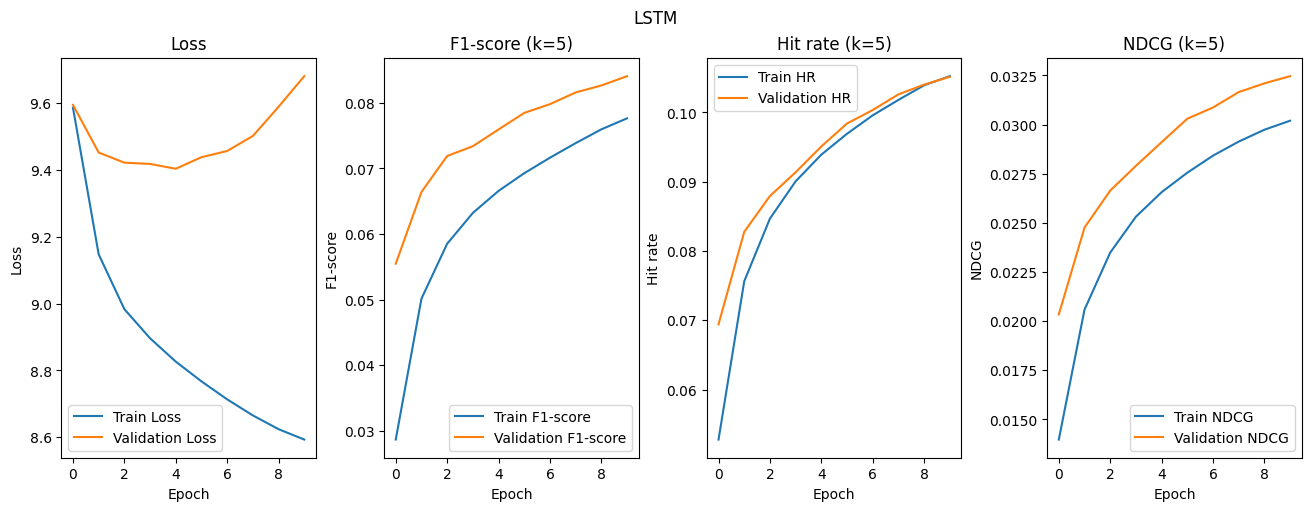

In [21]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(13, 5), constrained_layout=True)

plt.subplots_adjust(wspace=0.4)

ax1.plot(history_model_lstm.history['loss'], label='Train Loss')
ax1.plot(history_model_lstm.history['val_loss'], label='Validation Loss')
ax1.set_title('Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

ax2.plot(history_model_lstm.history['f1_score_at_k'], label='Train F1-score')
ax2.plot(history_model_lstm.history['val_f1_score_at_k'], label='Validation F1-score')
ax2.set_title('F1-score (k=5)')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('F1-score')
ax2.legend()

ax3.plot(history_model_lstm.history['hit_rate_at_k'], label='Train HR')
ax3.plot(history_model_lstm.history['val_hit_rate_at_k'], label='Validation HR')
ax3.set_title('Hit rate (k=5)')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('Hit rate')
ax3.legend()

ax4.plot(history_model_lstm.history['ndcg_at_k'], label='Train NDCG')
ax4.plot(history_model_lstm.history['val_ndcg_at_k'], label='Validation NDCG')
ax4.set_title('NDCG (k=5)')
ax4.set_xlabel('Epoch')
ax4.set_ylabel('NDCG')
ax4.legend()

plt.suptitle('LSTM')
plt.show()

In [22]:
model_lstm_test_loss, model_lstm_test_accuracy, model_lstm_test_f1_score, model_lstm_test_hr, model_lstm_test_ndcg = model_lstm.evaluate(test_dataset)

print("Test loss:", round(model_lstm_test_loss, 4))
print("Test accuracy:", round(model_lstm_test_accuracy, 4))
print("Test F1@5:", round(model_lstm_test_f1_score, 4))
print("Test HR@5:", round(model_lstm_test_hr, 4))
print("Test NDCG@5:", round(model_lstm_test_ndcg, 4))

parameters["model_lstm_test_loss"] = model_lstm_test_loss
parameters["model_lstm_test_accuracy"] = round(model_lstm_test_accuracy, 4)
parameters["model_lstm_test_f1_score"] = round(model_lstm_test_f1_score, 4)
parameters["model_lstm_test_hr"] = round(model_lstm_test_hr, 4)
parameters["model_lstm_test_ndcg"] = round(model_lstm_test_ndcg, 4)

3940/3940 ━━━━━━━━━━━━━━━━━━━━ 18s 5ms/step - accuracy: 0.0782 - f1_score_at_k: 0.0776 - hit_rate_at_k: 0.0943 - loss: nan - ndcg_at_k: 0.0294
Test loss: nan
Test accuracy: 0.0626
Test F1@5: 0.063
Test HR@5: 0.0781
Test NDCG@5: 0.024


In [23]:
parameters

{'number_of_users_in_total': 601263,
 'number_of_sequences_in_total': 601263,
 'number_of_sequences_after_filtering': 252156,
 'number_of_users_after_filtering': 252156,
 'sequence_length': 25,
 'number_of_sequences_and_targets_train': 1489192,
 'number_of_sequences_and_targets_validation': 252156,
 'number_of_sequences_and_targets_test': 252156,
 'model_lstm_test_loss': nan,
 'model_lstm_test_accuracy': 0.0626,
 'model_lstm_test_f1_score': 0.063,
 'model_lstm_test_hr': 0.0781,
 'model_lstm_test_ndcg': 0.024}

---------

## Bidirectional-LSTM

In [24]:
model_bi_lstm = Sequential()
model_bi_lstm.add(Embedding(input_dim=max_product_id, output_dim=50, mask_zero=True))
model_bi_lstm.add(Bidirectional(LSTM(32, activation='relu', return_sequences=True)))
model_bi_lstm.add(BatchNormalization())
model_bi_lstm.add(Dropout(0.2))
model_bi_lstm.add(Bidirectional(LSTM(32, activation='relu')))
model_bi_lstm.add(BatchNormalization())
model_bi_lstm.add(Dropout(0.2))
model_bi_lstm.add(Dense(16, activation='relu'))
model_bi_lstm.add(Dense(max_product_id, activation='softmax'))

model_bi_lstm.compile(
    loss='sparse_categorical_crossentropy', 
    optimizer=Adam(learning_rate=0.001), 
    metrics=['accuracy', f1_score_at_k, hit_rate_at_k, ndcg_at_k]
)

In [25]:
history_model_bi_lstm = model_bi_lstm.fit(
    train_dataset,
    epochs=25,
    batch_size=BATCH_SIZE,
    validation_data=val_dataset,
    callbacks=[EarlyStopping(monitor='val_loss', patience=5)]
)

Epoch 1/25
23269/23269 ━━━━━━━━━━━━━━━━━━━━ 474s 20ms/step - accuracy: 0.0389 - f1_score_at_k: 0.0353 - hit_rate_at_k: 0.0624 - loss: 9.6328 - ndcg_at_k: 0.0174 - val_accuracy: 0.0560 - val_f1_score_at_k: 0.0611 - val_hit_rate_at_k: 0.0744 - val_loss: 9.5690 - val_ndcg_at_k: 0.0224
Epoch 2/25
23269/23269 ━━━━━━━━━━━━━━━━━━━━ 446s 19ms/step - accuracy: 0.0635 - f1_score_at_k: 0.0669 - hit_rate_at_k: 0.0939 - loss: 8.9692 - ndcg_at_k: 0.0270 - val_accuracy: 0.0700 - val_f1_score_at_k: 0.0704 - val_hit_rate_at_k: 0.0869 - val_loss: 9.4120 - val_ndcg_at_k: 0.0268
Epoch 3/25
23269/23269 ━━━━━━━━━━━━━━━━━━━━ 448s 19ms/step - accuracy: 0.0762 - f1_score_at_k: 0.0769 - hit_rate_at_k: 0.1056 - loss: 8.7771 - ndcg_at_k: 0.0311 - val_accuracy: 0.0776 - val_f1_score_at_k: 0.0751 - val_hit_rate_at_k: 0.0932 - val_loss: 9.3441 - val_ndcg_at_k: 0.0291
Epoch 4/25
23269/23269 ━━━━━━━━━━━━━━━━━━━━ 447s 19ms/step - accuracy: 0.0835 - f1_score_at_k: 0.0825 - hit_rate_at_k: 0.1121 - loss: 8.6649 - ndcg_at_

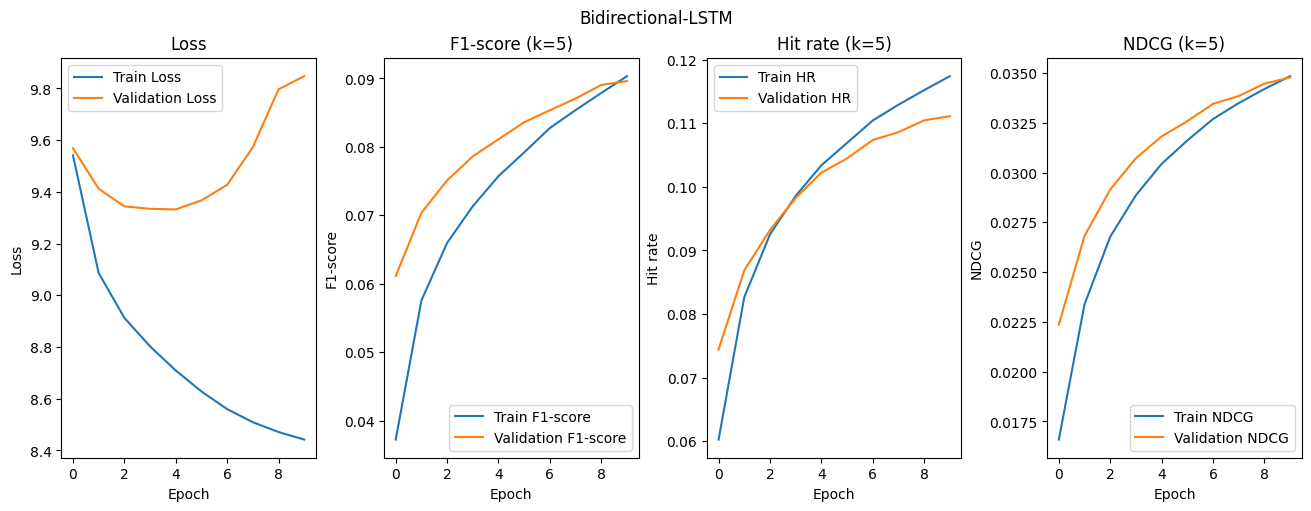

In [26]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(13, 5), constrained_layout=True)

plt.subplots_adjust(wspace=0.4)

ax1.plot(history_model_bi_lstm.history['loss'], label='Train Loss')
ax1.plot(history_model_bi_lstm.history['val_loss'], label='Validation Loss')
ax1.set_title('Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

ax2.plot(history_model_bi_lstm.history['f1_score_at_k'], label='Train F1-score')
ax2.plot(history_model_bi_lstm.history['val_f1_score_at_k'], label='Validation F1-score')
ax2.set_title('F1-score (k=5)')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('F1-score')
ax2.legend()

ax3.plot(history_model_bi_lstm.history['hit_rate_at_k'], label='Train HR')
ax3.plot(history_model_bi_lstm.history['val_hit_rate_at_k'], label='Validation HR')
ax3.set_title('Hit rate (k=5)')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('Hit rate')
ax3.legend()

ax4.plot(history_model_bi_lstm.history['ndcg_at_k'], label='Train NDCG')
ax4.plot(history_model_bi_lstm.history['val_ndcg_at_k'], label='Validation NDCG')
ax4.set_title('NDCG (k=5)')
ax4.set_xlabel('Epoch')
ax4.set_ylabel('NDCG')
ax4.legend()

plt.suptitle('Bidirectional-LSTM')
plt.show()

In [27]:
model_bi_lstm_test_loss, model_bi_lstm_test_accuracy, model_bi_lstm_test_f1_score, model_bi_lstm_test_hr, model_bi_lstm_test_ndcg = model_bi_lstm.evaluate(test_dataset)

print("Test loss:", round(model_bi_lstm_test_loss, 4))
print("Test accuracy:", round(model_bi_lstm_test_accuracy, 4))
print("Test F1@5:", round(model_bi_lstm_test_f1_score, 4))
print("Test HR@5:", round(model_bi_lstm_test_hr, 4))
print("Test NDCG@5:", round(model_bi_lstm_test_ndcg, 4))

parameters["model_bi_lstm_test_loss"] = model_bi_lstm_test_loss
parameters["model_bi_lstm_test_accuracy"] = round(model_bi_lstm_test_accuracy, 4)
parameters["model_bi_lstm_test_f1_score"] = round(model_bi_lstm_test_f1_score, 4)
parameters["model_bi_lstm_test_hr"] = round(model_bi_lstm_test_hr, 4)
parameters["model_bi_lstm_test_ndcg"] = round(model_bi_lstm_test_ndcg, 4)

3940/3940 ━━━━━━━━━━━━━━━━━━━━ 23s 6ms/step - accuracy: 0.0855 - f1_score_at_k: 0.0823 - hit_rate_at_k: 0.0997 - loss: nan - ndcg_at_k: 0.0315
Test loss: nan
Test accuracy: 0.0696
Test F1@5: 0.0677
Test HR@5: 0.0831
Test NDCG@5: 0.026


In [28]:
parameters

{'number_of_users_in_total': 601263,
 'number_of_sequences_in_total': 601263,
 'number_of_sequences_after_filtering': 252156,
 'number_of_users_after_filtering': 252156,
 'sequence_length': 25,
 'number_of_sequences_and_targets_train': 1489192,
 'number_of_sequences_and_targets_validation': 252156,
 'number_of_sequences_and_targets_test': 252156,
 'model_lstm_test_loss': nan,
 'model_lstm_test_accuracy': 0.0626,
 'model_lstm_test_f1_score': 0.063,
 'model_lstm_test_hr': 0.0781,
 'model_lstm_test_ndcg': 0.024,
 'model_bi_lstm_test_loss': nan,
 'model_bi_lstm_test_accuracy': 0.0696,
 'model_bi_lstm_test_f1_score': 0.0677,
 'model_bi_lstm_test_hr': 0.0831,
 'model_bi_lstm_test_ndcg': 0.026}

-----------

## GRU

In [29]:
model_gru = Sequential()
model_gru.add(Embedding(input_dim=max_product_id, output_dim=50, mask_zero=True))
model_gru.add(GRU(32, activation='relu', return_sequences=True))
model_gru.add(BatchNormalization())
model_gru.add(Dropout(0.2))
model_gru.add(GRU(32, activation='relu'))
model_gru.add(BatchNormalization())
model_gru.add(Dropout(0.2))
model_gru.add(Dense(16, activation='relu'))
model_gru.add(Dense(max_product_id, activation='softmax'))

model_gru.compile(
    loss='sparse_categorical_crossentropy', 
    optimizer=Adam(learning_rate=0.001), 
    metrics=['accuracy', f1_score_at_k, hit_rate_at_k, ndcg_at_k]
)

In [30]:
history_model_gru = model_gru.fit(
    train_dataset,
    epochs=25,
    batch_size=BATCH_SIZE,
    validation_data=val_dataset,
    callbacks=[EarlyStopping(monitor='val_loss', patience=5)]
)

Epoch 1/25
23269/23269 ━━━━━━━━━━━━━━━━━━━━ 345s 14ms/step - accuracy: 0.0339 - f1_score_at_k: 0.0291 - hit_rate_at_k: 0.0578 - loss: 9.6757 - ndcg_at_k: 0.0157 - val_accuracy: 0.0526 - val_f1_score_at_k: 0.0578 - val_hit_rate_at_k: 0.0713 - val_loss: 9.6033 - val_ndcg_at_k: 0.0213
Epoch 2/25
23269/23269 ━━━━━━━━━━━━━━━━━━━━ 325s 14ms/step - accuracy: 0.0528 - f1_score_at_k: 0.0566 - hit_rate_at_k: 0.0842 - loss: 9.0981 - ndcg_at_k: 0.0235 - val_accuracy: 0.0588 - val_f1_score_at_k: 0.0635 - val_hit_rate_at_k: 0.0798 - val_loss: 9.4950 - val_ndcg_at_k: 0.0238
Epoch 3/25
23269/23269 ━━━━━━━━━━━━━━━━━━━━ 326s 14ms/step - accuracy: 0.0602 - f1_score_at_k: 0.0638 - hit_rate_at_k: 0.0937 - loss: 8.9241 - ndcg_at_k: 0.0264 - val_accuracy: 0.0637 - val_f1_score_at_k: 0.0685 - val_hit_rate_at_k: 0.0852 - val_loss: 9.4337 - val_ndcg_at_k: 0.0255
Epoch 4/25
23269/23269 ━━━━━━━━━━━━━━━━━━━━ 324s 14ms/step - accuracy: 0.0651 - f1_score_at_k: 0.0691 - hit_rate_at_k: 0.0990 - loss: 8.8343 - ndcg_at_

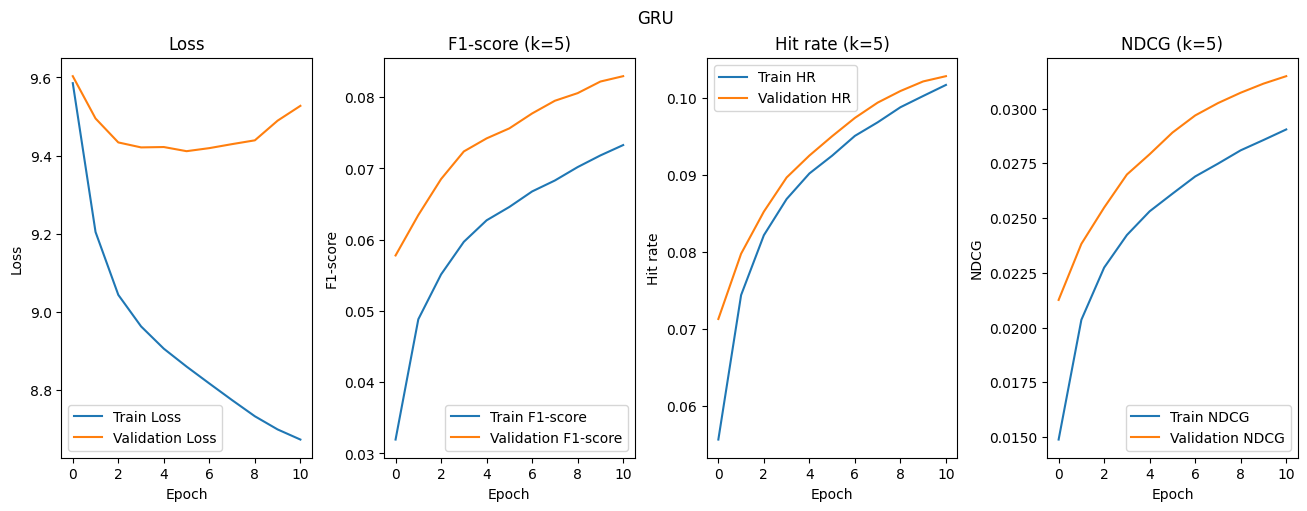

In [31]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(13, 5), constrained_layout=True)

plt.subplots_adjust(wspace=0.4)

ax1.plot(history_model_gru.history['loss'], label='Train Loss')
ax1.plot(history_model_gru.history['val_loss'], label='Validation Loss')
ax1.set_title('Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

ax2.plot(history_model_gru.history['f1_score_at_k'], label='Train F1-score')
ax2.plot(history_model_gru.history['val_f1_score_at_k'], label='Validation F1-score')
ax2.set_title('F1-score (k=5)')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('F1-score')
ax2.legend()

ax3.plot(history_model_gru.history['hit_rate_at_k'], label='Train HR')
ax3.plot(history_model_gru.history['val_hit_rate_at_k'], label='Validation HR')
ax3.set_title('Hit rate (k=5)')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('Hit rate')
ax3.legend()

ax4.plot(history_model_gru.history['ndcg_at_k'], label='Train NDCG')
ax4.plot(history_model_gru.history['val_ndcg_at_k'], label='Validation NDCG')
ax4.set_title('NDCG (k=5)')
ax4.set_xlabel('Epoch')
ax4.set_ylabel('NDCG')
ax4.legend()

plt.suptitle('GRU')
plt.show()

In [ ]:
model_gru_test_loss, model_gru_test_accuracy, model_gru_test_f1_score, model_gru_test_hr, model_gru_test_ndcg = model_gru.evaluate(test_dataset)

print("Test loss:", round(model_gru_test_loss, 4))
print("Test accuracy:", round(model_gru_test_accuracy, 4))
print("Test F1@5:", round(model_gru_test_f1_score, 4))
print("Test HR@5:", round(model_gru_test_hr, 4))
print("Test NDCG@5:", round(model_gru_test_ndcg, 4))

parameters["model_gru_test_loss"] = model_gru_test_loss
parameters["model_gru_test_accuracy"] = round(model_gru_test_accuracy, 4)
parameters["model_gru_test_f1_score"] = round(model_gru_test_f1_score, 4)
parameters["model_gru_test_hr"] = round(model_gru_test_hr, 4)
parameters["model_gru_test_ndcg"] = round(model_gru_test_ndcg, 4)

3940/3940 ━━━━━━━━━━━━━━━━━━━━ 18s 5ms/step - accuracy: 0.0754 - f1_score_at_k: 0.0767 - hit_rate_at_k: 0.0921 - loss: nan - ndcg_at_k: 0.0285
Test loss: nan
Test accuracy: 0.0602
Test F1@5: 0.0626
Test HR@5: 0.0763
Test NDCG@5: 0.0233


In [ ]:
parameters

{'number_of_users_in_total': 601263,
 'number_of_sequences_in_total': 601263,
 'number_of_sequences_after_filtering': 252156,
 'number_of_users_after_filtering': 252156,
 'sequence_length': 25,
 'number_of_sequences_and_targets_train': 1489192,
 'number_of_sequences_and_targets_validation': 252156,
 'number_of_sequences_and_targets_test': 252156,
 'model_lstm_test_loss': nan,
 'model_lstm_test_accuracy': 0.0626,
 'model_lstm_test_f1_score': 0.063,
 'model_lstm_test_hr': 0.0781,
 'model_lstm_test_ndcg': 0.024,
 'model_bi_lstm_test_loss': nan,
 'model_bi_lstm_test_accuracy': 0.0696,
 'model_bi_lstm_test_f1_score': 0.0677,
 'model_bi_lstm_test_hr': 0.0831,
 'model_bi_lstm_test_ndcg': 0.026,
 'model_gru_test_loss': nan,
 'model_gru_test_accuracy': 0.0602,
 'model_gru_test_f1_score': 0.0626,
 'model_gru_test_hr': 0.0763,
 'model_gru_test_ndcg': 0.0233}

--------

## Autoencoder

In [ ]:
nn = [64, 32, 16, 32, 64]

model_autoencoder = Sequential()
model_autoencoder.add(Embedding(input_dim=max_product_id, output_dim=50, mask_zero=True))
model_autoencoder.add(Flatten())
model_autoencoder.add(Dense(units=nn[0], activation='relu'))
model_autoencoder.add(BatchNormalization())
model_autoencoder.add(Dropout(0.2))
for n in nn[1:]:
    model_autoencoder.add(Dense(units=n, activation='relu'))
    model_autoencoder.add(BatchNormalization())
    model_autoencoder.add(Dropout(0.2))
model_autoencoder.add(Dense(max_product_id, activation='softmax'))

model_autoencoder.compile(
    loss='sparse_categorical_crossentropy', 
    optimizer=Adam(learning_rate=0.001), 
    metrics=['accuracy', f1_score_at_k, hit_rate_at_k, ndcg_at_k]
)

In [35]:
history_model_autoencoder = model_autoencoder.fit(
    train_dataset,
    epochs=25,
    batch_size=BATCH_SIZE,
    validation_data=val_dataset,
    callbacks=[EarlyStopping(monitor='val_loss', patience=5)]
)

Epoch 1/25
23269/23269 ━━━━━━━━━━━━━━━━━━━━ 244s 10ms/step - accuracy: 0.0265 - f1_score_at_k: 0.0185 - hit_rate_at_k: 0.0480 - loss: 9.7790 - ndcg_at_k: 0.0128 - val_accuracy: 0.0359 - val_f1_score_at_k: 0.0461 - val_hit_rate_at_k: 0.0628 - val_loss: 9.4254 - val_ndcg_at_k: 0.0169
Epoch 2/25
23269/23269 ━━━━━━━━━━━━━━━━━━━━ 218s 9ms/step - accuracy: 0.0399 - f1_score_at_k: 0.0422 - hit_rate_at_k: 0.0748 - loss: 8.9615 - ndcg_at_k: 0.0197 - val_accuracy: 0.0466 - val_f1_score_at_k: 0.0578 - val_hit_rate_at_k: 0.0738 - val_loss: 9.3295 - val_ndcg_at_k: 0.0206
Epoch 3/25
23269/23269 ━━━━━━━━━━━━━━━━━━━━ 218s 9ms/step - accuracy: 0.0467 - f1_score_at_k: 0.0525 - hit_rate_at_k: 0.0849 - loss: 8.8693 - ndcg_at_k: 0.0226 - val_accuracy: 0.0518 - val_f1_score_at_k: 0.0627 - val_hit_rate_at_k: 0.0801 - val_loss: 9.3853 - val_ndcg_at_k: 0.0225
Epoch 4/25
23269/23269 ━━━━━━━━━━━━━━━━━━━━ 218s 9ms/step - accuracy: 0.0504 - f1_score_at_k: 0.0577 - hit_rate_at_k: 0.0905 - loss: 8.8265 - ndcg_at_k: 

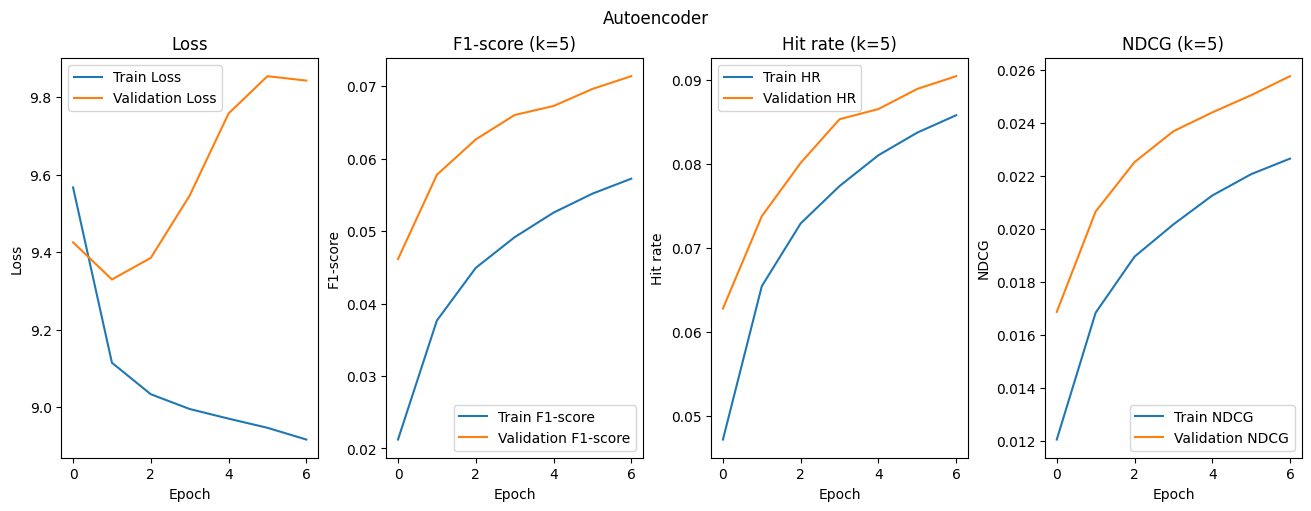

In [36]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(13, 5), constrained_layout=True)

plt.subplots_adjust(wspace=0.4)

ax1.plot(history_model_autoencoder.history['loss'], label='Train Loss')
ax1.plot(history_model_autoencoder.history['val_loss'], label='Validation Loss')
ax1.set_title('Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

ax2.plot(history_model_autoencoder.history['f1_score_at_k'], label='Train F1-score')
ax2.plot(history_model_autoencoder.history['val_f1_score_at_k'], label='Validation F1-score')
ax2.set_title('F1-score (k=5)')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('F1-score')
ax2.legend()

ax3.plot(history_model_autoencoder.history['hit_rate_at_k'], label='Train HR')
ax3.plot(history_model_autoencoder.history['val_hit_rate_at_k'], label='Validation HR')
ax3.set_title('Hit rate (k=5)')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('Hit rate')
ax3.legend()

ax4.plot(history_model_autoencoder.history['ndcg_at_k'], label='Train NDCG')
ax4.plot(history_model_autoencoder.history['val_ndcg_at_k'], label='Validation NDCG')
ax4.set_title('NDCG (k=5)')
ax4.set_xlabel('Epoch')
ax4.set_ylabel('NDCG')
ax4.legend()

plt.suptitle('Autoencoder')
plt.show()

In [37]:
model_autoencoder_test_loss, model_autoencoder_test_accuracy, model_autoencoder_test_f1_score, model_autoencoder_test_hr, model_autoencoder_test_ndcg = model_autoencoder.evaluate(test_dataset)

print("Test loss:", round(model_autoencoder_test_loss, 4))
print("Test accuracy:", round(model_autoencoder_test_accuracy, 4))
print("Test F1@5:", round(model_autoencoder_test_f1_score, 4))
print("Test HR@5:", round(model_autoencoder_test_hr, 4))
print("Test NDCG@5:", round(model_autoencoder_test_ndcg, 4))

parameters["model_autoencoder_test_loss"] = model_autoencoder_test_loss
parameters["model_autoencoder_test_accuracy"] = round(model_autoencoder_test_accuracy, 4)
parameters["model_autoencoder_test_f1_score"] = round(model_autoencoder_test_f1_score, 4)
parameters["model_autoencoder_test_hr"] = round(model_autoencoder_test_hr, 4)
parameters["model_autoencoder_test_ndcg"] = round(model_autoencoder_test_ndcg, 4)

3940/3940 ━━━━━━━━━━━━━━━━━━━━ 16s 4ms/step - accuracy: 0.0560 - f1_score_at_k: 0.0685 - hit_rate_at_k: 0.0816 - loss: nan - ndcg_at_k: 0.0236
Test loss: nan
Test accuracy: 0.0421
Test F1@5: 0.0533
Test HR@5: 0.0654
Test NDCG@5: 0.0184


In [38]:
parameters

{'number_of_users_in_total': 601263,
 'number_of_sequences_in_total': 601263,
 'number_of_sequences_after_filtering': 252156,
 'number_of_users_after_filtering': 252156,
 'sequence_length': 25,
 'number_of_sequences_and_targets_train': 1489192,
 'number_of_sequences_and_targets_validation': 252156,
 'number_of_sequences_and_targets_test': 252156,
 'model_lstm_test_loss': nan,
 'model_lstm_test_accuracy': 0.0626,
 'model_lstm_test_f1_score': 0.063,
 'model_lstm_test_hr': 0.0781,
 'model_lstm_test_ndcg': 0.024,
 'model_bi_lstm_test_loss': nan,
 'model_bi_lstm_test_accuracy': 0.0696,
 'model_bi_lstm_test_f1_score': 0.0677,
 'model_bi_lstm_test_hr': 0.0831,
 'model_bi_lstm_test_ndcg': 0.026,
 'model_gru_test_loss': nan,
 'model_gru_test_accuracy': 0.0602,
 'model_gru_test_f1_score': 0.0626,
 'model_gru_test_hr': 0.0763,
 'model_gru_test_ndcg': 0.0233,
 'model_autoencoder_test_loss': nan,
 'model_autoencoder_test_accuracy': 0.0421,
 'model_autoencoder_test_f1_score': 0.0533,
 'model_autoenc

-------

## CNN

In [39]:
model_cnn = Sequential()
model_cnn.add(Embedding(input_dim=max_product_id, output_dim=50, mask_zero=True))
model_cnn.add(Conv1D(64, 3, activation='relu', padding='same'))
model_cnn.add(BatchNormalization())
model_cnn.add(Dropout(0.2))
#model_cnn.add(MaxPooling1D(2))
model_cnn.add(Conv1D(64, 3, activation='relu', padding='same'))
model_cnn.add(BatchNormalization())
model_cnn.add(Dropout(0.2))
model_cnn.add(GlobalMaxPooling1D())
model_cnn.add(Dense(16, activation='relu'))
model_cnn.add(Dense(max_product_id, activation='softmax'))

model_cnn.compile(
    loss='sparse_categorical_crossentropy', 
    optimizer=Adam(learning_rate=0.001), 
    metrics=['accuracy', f1_score_at_k, hit_rate_at_k, ndcg_at_k]
)

In [40]:
history_model_cnn = model_cnn.fit(
    train_dataset,
    epochs=25,
    batch_size=BATCH_SIZE,
    validation_data=val_dataset,
    callbacks=[EarlyStopping(monitor='val_loss', patience=5)]
)

Epoch 1/25
23269/23269 ━━━━━━━━━━━━━━━━━━━━ 206s 9ms/step - accuracy: 0.0417 - f1_score_at_k: 0.0364 - hit_rate_at_k: 0.0643 - loss: 9.5716 - ndcg_at_k: 0.0182 - val_accuracy: 0.0580 - val_f1_score_at_k: 0.0579 - val_hit_rate_at_k: 0.0738 - val_loss: 9.7008 - val_ndcg_at_k: 0.0226
Epoch 2/25
23269/23269 ━━━━━━━━━━━━━━━━━━━━ 190s 8ms/step - accuracy: 0.0679 - f1_score_at_k: 0.0669 - hit_rate_at_k: 0.0960 - loss: 8.8983 - ndcg_at_k: 0.0281 - val_accuracy: 0.0667 - val_f1_score_at_k: 0.0673 - val_hit_rate_at_k: 0.0827 - val_loss: 9.6024 - val_ndcg_at_k: 0.0255
Epoch 3/25
23269/23269 ━━━━━━━━━━━━━━━━━━━━ 191s 8ms/step - accuracy: 0.0778 - f1_score_at_k: 0.0761 - hit_rate_at_k: 0.1057 - loss: 8.7320 - ndcg_at_k: 0.0314 - val_accuracy: 0.0691 - val_f1_score_at_k: 0.0713 - val_hit_rate_at_k: 0.0867 - val_loss: 9.6116 - val_ndcg_at_k: 0.0266
Epoch 4/25
23269/23269 ━━━━━━━━━━━━━━━━━━━━ 192s 8ms/step - accuracy: 0.0840 - f1_score_at_k: 0.0819 - hit_rate_at_k: 0.1117 - loss: 8.6241 - ndcg_at_k: 0

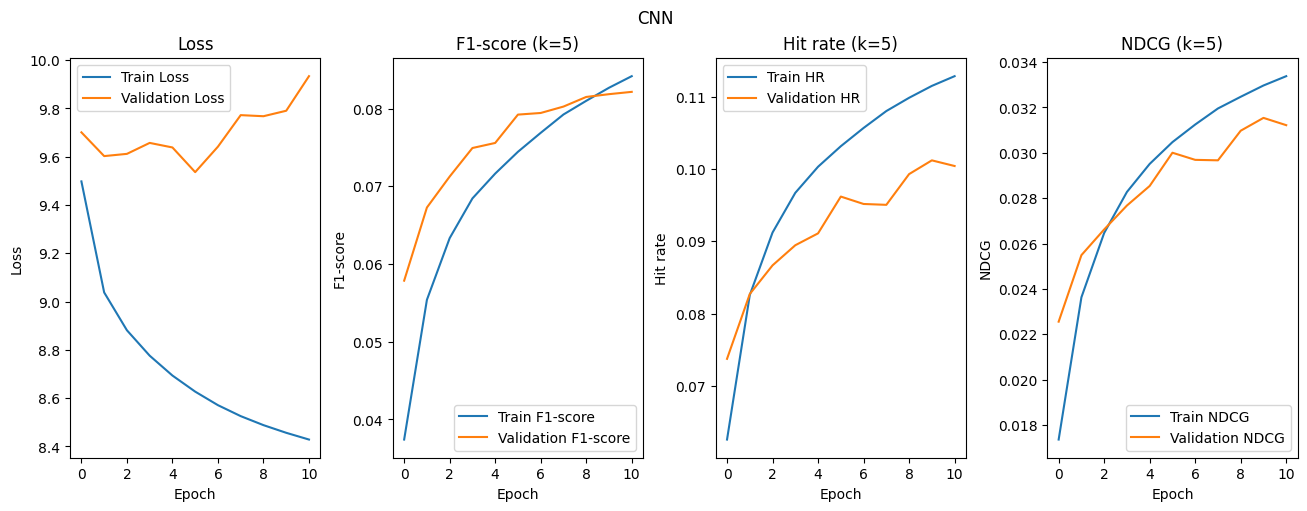

In [41]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(13, 5), constrained_layout=True)

plt.subplots_adjust(wspace=0.4)

ax1.plot(history_model_cnn.history['loss'], label='Train Loss')
ax1.plot(history_model_cnn.history['val_loss'], label='Validation Loss')
ax1.set_title('Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

ax2.plot(history_model_cnn.history['f1_score_at_k'], label='Train F1-score')
ax2.plot(history_model_cnn.history['val_f1_score_at_k'], label='Validation F1-score')
ax2.set_title('F1-score (k=5)')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('F1-score')
ax2.legend()

ax3.plot(history_model_cnn.history['hit_rate_at_k'], label='Train HR')
ax3.plot(history_model_cnn.history['val_hit_rate_at_k'], label='Validation HR')
ax3.set_title('Hit rate (k=5)')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('Hit rate')
ax3.legend()

ax4.plot(history_model_cnn.history['ndcg_at_k'], label='Train NDCG')
ax4.plot(history_model_cnn.history['val_ndcg_at_k'], label='Validation NDCG')
ax4.set_title('NDCG (k=5)')
ax4.set_xlabel('Epoch')
ax4.set_ylabel('NDCG')
ax4.legend()

plt.suptitle('CNN')
plt.show()

In [42]:
model_cnn_test_loss, model_cnn_test_accuracy, model_cnn_test_f1_score, model_cnn_test_hr, model_cnn_test_ndcg = model_cnn.evaluate(test_dataset)

print("Test loss:", round(model_cnn_test_loss, 4))
print("Test accuracy:", round(model_cnn_test_accuracy, 4))
print("Test F1@5:", round(model_cnn_test_f1_score, 4))
print("Test HR@5:", round(model_cnn_test_hr, 4))
print("Test NDCG@5:", round(model_cnn_test_ndcg, 4))

parameters["model_cnn_test_loss"] = model_cnn_test_loss
parameters["model_cnn_test_accuracy"] = round(model_cnn_test_accuracy, 4)
parameters["model_cnn_test_f1_score"] = round(model_cnn_test_f1_score, 4)
parameters["model_cnn_test_hr"] = round(model_cnn_test_hr, 4)
parameters["model_cnn_test_ndcg"] = round(model_cnn_test_ndcg, 4)

3940/3940 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.0773 - f1_score_at_k: 0.0766 - hit_rate_at_k: 0.0919 - loss: nan - ndcg_at_k: 0.0288
Test loss: nan
Test accuracy: 0.061
Test F1@5: 0.0614
Test HR@5: 0.0752
Test NDCG@5: 0.0232


------

In [43]:
parameters

{'number_of_users_in_total': 601263,
 'number_of_sequences_in_total': 601263,
 'number_of_sequences_after_filtering': 252156,
 'number_of_users_after_filtering': 252156,
 'sequence_length': 25,
 'number_of_sequences_and_targets_train': 1489192,
 'number_of_sequences_and_targets_validation': 252156,
 'number_of_sequences_and_targets_test': 252156,
 'model_lstm_test_loss': nan,
 'model_lstm_test_accuracy': 0.0626,
 'model_lstm_test_f1_score': 0.063,
 'model_lstm_test_hr': 0.0781,
 'model_lstm_test_ndcg': 0.024,
 'model_bi_lstm_test_loss': nan,
 'model_bi_lstm_test_accuracy': 0.0696,
 'model_bi_lstm_test_f1_score': 0.0677,
 'model_bi_lstm_test_hr': 0.0831,
 'model_bi_lstm_test_ndcg': 0.026,
 'model_gru_test_loss': nan,
 'model_gru_test_accuracy': 0.0602,
 'model_gru_test_f1_score': 0.0626,
 'model_gru_test_hr': 0.0763,
 'model_gru_test_ndcg': 0.0233,
 'model_autoencoder_test_loss': nan,
 'model_autoencoder_test_accuracy': 0.0421,
 'model_autoencoder_test_f1_score': 0.0533,
 'model_autoenc